# Final Project Submission

* Student name: Andro Tikvica
* Student pace: Self Paced
* Scheduled project review date/time: Monday 05/10/2020 15:30 DST
* Instructor name: Jeffrey Herman
* Blog post URL:

### Work Packages 
***

In [2]:
import numpy as np # for numbers and stuff
import os # to help renaming files
import pandas as pd # for creating and manipulating tables
from glob import glob # will use this to facilitate accessing all file names in one go
import datetime # to convert strings to datetime
from scipy import stats # to calculate zscore to remove outliers
pd.set_option('display.max_rows', None) # to extend the number of rows that show in a data frame
import sqlite3
from collections import Counter # to count occurrences of genres
import matplotlib.pyplot as plt # for creating visualizations
%matplotlib inline
import seaborn as sns # to simplify complex visualizations
sns.set_style(style="darkgrid") # uses a cool backdrop for sns plots

### Loading Files
***
Create two lists of the files contained in the Zipped Data folder, one for the csv files and tsv files. There is a separate Data Load file in this repository that contains a more elegant data load, but this basic load ended up being sufficient. 

In [3]:
# Access each file within the zippedData folder. 
csv_files = glob("zippedData\*.csv.gz") 
# This line 
tsv_files = glob("zippedData\*.tsv.gz")

print("csv Files:")
[print(i) for i in csv_files]
print("\ntsv Files:")
[print(i) for i in tsv_files]

print("\n",f"Total files: {len(csv_files)} + {len(tsv_files)}")

csv Files:
zippedData\bom.movie_gross.csv.gz
zippedData\imdb.name.basics.csv.gz
zippedData\imdb.title.akas.csv.gz
zippedData\imdb.title.basics.csv.gz
zippedData\imdb.title.crew.csv.gz
zippedData\imdb.title.principals.csv.gz
zippedData\imdb.title.ratings.csv.gz
zippedData\tmdb.movies.csv.gz
zippedData\tn.movie_budgets.csv.gz

tsv Files:
zippedData\rt.movie_info.tsv.gz
zippedData\rt.reviews.tsv.gz

 Total files: 9 + 2


#### Dictionary of file names and data frames
This was made to facilitate the SQL connection and to facilitate easier loading. However, I did not end up using it beyond the SQL load. 

In [4]:
movie_files = {}

for i in csv_files:
    key = os.path.basename(i).replace(".csv", "").replace(".gz", "").replace(".", "_")
    value = pd.read_csv(i)
    movie_files[key] = value

    
for i in tsv_files:
    key = os.path.basename(i).replace(".tsv", "").replace(".gz", "").replace(".", "_")
    value = pd.read_csv(i, sep = '\t', encoding = 'unicode_escape')
    #tsv files are tab seperated values
    #by including encoding it avoids errors thrown up by non-ascii characters
    movie_files[key] = value    

movie_files.keys()

dict_keys(['bom_movie_gross', 'imdb_name_basics', 'imdb_title_akas', 'imdb_title_basics', 'imdb_title_crew', 'imdb_title_principals', 'imdb_title_ratings', 'tmdb_movies', 'tn_movie_budgets', 'rt_movie_info', 'rt_reviews'])

### Connecting to SQL Database
***
#### Create a sqlite file
The SQL file itself will not be pushed onto github as it exceeds 100 mb.

In [4]:
# This creates a blank SQL database
conn = sqlite3.connect("movie_db.sqlite")
cur = conn.cursor()

# Create SQL Table for each Dataframe in movie_files
test = 1
for name, table in movie_files.items():
    table.to_sql(name, conn)
    print(f"Table {test}: {name}")
    test += 1

# Show each table present in database
conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

Table 1: bom_movie_gross
Table 2: imdb_name_basics
Table 3: imdb_title_akas
Table 4: imdb_title_basics
Table 5: imdb_title_crew
Table 6: imdb_title_principals
Table 7: imdb_title_ratings


C:\Users\joyti\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:2712: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


Table 8: tmdb_movies
Table 9: tn_movie_budgets
Table 10: rt_movie_info
Table 11: rt_reviews


[('bom_movie_gross',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('tmdb_movies',),
 ('tn_movie_budgets',),
 ('rt_movie_info',),
 ('rt_reviews',)]

### Inspecting the Dataframes
***

In [5]:
for i in csv_files:
    df_title = pd.read_csv(i)
    print(i)
    print("Columns:\n", df_title.columns, "\n\n", "Info:")
    print(df_title.info(), "\n")
    print("Null values:\n", df_title.isna().sum(), "\n")
    print("Shape:\n", df_title.shape, "\n")

zippedData\bom.movie_gross.csv.gz
Columns:
 Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object') 

 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None 

Null values:
 title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64 

Shape:
 (3387, 5) 

zippedData\imdb.name.basics.csv.gz
Columns:
 Index(['nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles'],
      dtype='object') 

 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
nconst                606648

## Cleaning Budgets
***
### Load and Clean tn_movie_budgets
Load
1. Just loading the specific csv file. Selection was based on seeing that there were no null values and it covered a vital topic. 

Object to int
2. Converted the contents of three columns into ints for computation. Stripped the dollar sign and replaced commas with nothing as could not replace both commas and dollar sign in one parentheses (for whatever reason). 

Datetime
3. Converted the release_date column to date time to allow for computation. Had to import datetime to use this. Additionally only showed year to allow it to merge on date with df_budgets_2.

ROI
4. Created a new series to contain the Return on Investment ((total gross - production budget) / production budget). the equation also multiplies the result by 100 to make it a percentage and rounds to a single decimal place to still have a degree of accuracy while still being easy to read. 

Drop ROI == -100
5. Removing all movies where ROI is -100. This primarily removed movies that had missing data. 

1995 onwards
6. Removed all movies released before 1995. It reduced the sample size significantly, but, recent data is far more relevant in determining future trends. An example is the movie Deep Throat, the highest ROI of all the movies on the original list, is a pornographic film from the 70's. This film would not only never make it to theatres today, it does not represent the current state of media. 

Presenting returns as absolute values is irrelevant (a 500 million gross may sound large unless you spend 490 million making the movie). By having an ROI calculation the relative success of a movie is instantly visible.

In [6]:
df_budgets = pd.read_csv(csv_files[-1])

# Figures are objects (as seen above), they need to be converted to ints.
df_budgets['production_budget'] = df_budgets['production_budget'].map(lambda x: int(x.replace(',', '').strip('$')))
df_budgets['domestic_gross'] = df_budgets['domestic_gross'].map(lambda x: int(x.replace(',', '').strip('$')))
df_budgets['worldwide_gross'] = df_budgets['worldwide_gross'].map(lambda x: int(x.replace(',', '').strip('$')))

# Date conversion into datetime
df_budgets['release_date'] = df_budgets['release_date'].map(lambda x: datetime.datetime.strptime(x, '%b %d, %Y'))

# Removing month and day will make merging more accurate
df_budgets['release_date'] = df_budgets['release_date'].map(lambda x: x.year)

# New Column for ROI
sum_budgets = round((((df_budgets['worldwide_gross'] - df_budgets['production_budget'] ) / df_budgets['production_budget']) * 100), 1)
df_budgets['roi_%'] = sum_budgets

# Drop ROI == -100 
to_drop_b = df_budgets.loc[df_budgets['roi_%'] == -100].index
df_budgets.drop(to_drop_b, axis = 0, inplace = True)

# 1995 onwards
df_budgets = df_budgets.loc[df_budgets['release_date'] > 1995]

# Set id to index
df_budgets.set_index('id', inplace = True)

print("ROI Mean:", round(df_budgets["roi_%"].mean(), 2), "%")
print(df_budgets.shape)
df_budgets.head()

ROI Mean: 270.91 %
(4573, 6)


,release_date,movie,production_budget,domestic_gross,worldwide_gross,roi_%
id,,,,,,
1,2009,Avatar,425000000,760507625,2776345279,553.3
2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,154.7
3,2019,Dark Phoenix,350000000,42762350,149762350,-57.2
4,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,324.4
5,2017,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,315.4


### Load and Clean bom_movie_gross
***
The main intention with the second budgets Data Frame is to merge it with the first one. The main addition here will be the 'studio column'. My reason for merging onto the first budgets Data Frame is that it already contains production budget. This allows for easier calculation of the ROI. The studio column will be used to determine which studio is the best choice to partner with in making a film. This will be based on ROI. 

In terms of merge-compatibility the first issue spotted was that some of the titles in the second df contained the year of release in parentheses after the title. 323 times versus 8 in the first one. This meant that the same movies might not match up in the merge. The for loop identified all of the id's of titles that ended with a parentheses. The second for loop then identified which of these contained a digit in the -2 position of the title string. This ensured that we weren't deleting parentheses that contained words. The second for loop also cut everything from the space and parentheses.

In [7]:
df_budgets_2 = pd.read_csv(csv_files[0])

# Check how many titles end in ')' 
title_series = df_budgets_2['title']
title_series.str.endswith(')').sum()
print(f"df_series_2 ending in parentheses: {title_series.str.endswith(')').sum()}")

# Checking whether df_budgets has names ending in parentheses as well. 
title_series_2 = df_budgets['movie']
print(f"df_series ending in parentheses: {title_series_2.str.endswith(')').sum()}")

# Earliest movie on this df is 2010 so did not have to remove old movies.
      
# For Loop to find id of perpetrators
num = 0
tracker = []
for i in title_series.str.endswith(')'):
    if i == False:
        num += 1
    else:
        tracker.append(num)
        num += 1
len(tracker)

# Delete parentheses
for i in tracker:
    if df_budgets_2.loc[i]['title'][-2].isdigit():
        df_budgets_2.at[i,'title'] = df_budgets_2.loc[i]['title'].split(' (', 1)[0]
    
df_budgets_2.head() 

df_series_2 ending in parentheses: 323
df_series ending in parentheses: 8


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland,BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### Budgets Merge
***
Merged left onto df_budgets as it contained production budget data and ROI. The merge was done on two separate columns: movie title and release year. Duplicated columns were dropped.

Only 1322 rows managed to merge studio data. This will be sufficient to cross examine the results gained form judging the value of studio partners with Mean Total Gross as opposed to Mean ROI. 

In [8]:
# Creating a new dataframe that has budgets, ROI and studio data
df = df_budgets.merge(df_budgets_2, left_on = ['movie',  'release_date'], 
                        right_on= ['title', 'year'], how= 'left')

# Tested whether there were doubles but they were all two different movies with a shared name
# test['movie'].value_counts()

# Getting rid of duplicate columns, essentially only needed studio column
df.drop(['title', 'domestic_gross_y', 'foreign_gross', 'year'], axis= 1, inplace = True)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4573 entries, 0 to 4572
Data columns (total 7 columns):
release_date         4573 non-null int64
movie                4573 non-null object
production_budget    4573 non-null int64
domestic_gross_x     4573 non-null int64
worldwide_gross      4573 non-null int64
roi_%                4573 non-null float64
studio               1322 non-null object
dtypes: float64(1), int64(4), object(2)
memory usage: 285.8+ KB
None


,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,roi_%,studio
0,2009,Avatar,425000000,760507625,2776345279,553.3,NaN
1,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,154.7,BV
2,2019,Dark Phoenix,350000000,42762350,149762350,-57.2,NaN
3,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,324.4,BV
4,2017,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,315.4,NaN


## Question 1: Is there correlation between Ratings and Return on Investment?
***
First off, the basis of this question and much of this research paper is that Gross returns (Box Office) are a useless indicator of a movies success. The real value to investors is the relative return on investment. This question is checking whether Ratings have any correlation with Return on Investment (ROI). This will determine whether further questions are measured by ratings or ROI alone. 

#### SQL code

In [9]:
# Select the columns to and dataframes to merge and on what column
cur.execute('''SELECT imdb_title_ratings.*, primary_title, original_title, start_year, runtime_minutes, genres
               FROM imdb_title_ratings
               JOIN imdb_title_basics
               ON imdb_title_ratings.tconst = imdb_title_basics.tconst
''')
df_imdb_ratings = pd.DataFrame(cur.fetchall())

# Set column names
df_imdb_ratings.columns = [i[0] for i in cur.description]

# df_imdb_ratings.set_index('index')
print(df_imdb_ratings.info())
df_imdb_ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 9 columns):
index              73856 non-null int64
tconst             73856 non-null object
averagerating      73856 non-null float64
numvotes           73856 non-null int64
primary_title      73856 non-null object
original_title     73856 non-null object
start_year         73856 non-null int64
runtime_minutes    66236 non-null float64
genres             73052 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 5.1+ MB
None


,index,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,0,tt10356526,8.3,31,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,1,tt10384606,8.9,559,Borderless,Borderless,2019,87.0,Documentary
2,2,tt1042974,6.4,20,Just Inès,Just Inès,2010,90.0,Drama
3,3,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy"
4,4,tt1060240,6.5,21,Até Onde?,Até Onde?,2011,73.0,"Mystery,Thriller"


#### Check Ratings Distribution
Graphing the ratings distribution will show whether the data is distributed as expected.

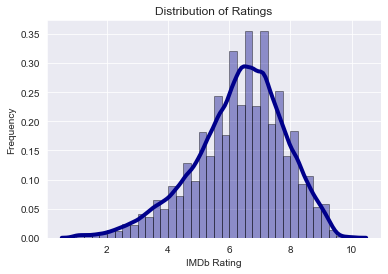

Earliest film on table: 2010


In [10]:
sns.distplot(df_imdb_ratings['averagerating'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor': 'black'},
            kde_kws = {'linewidth': 4})
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

# This graph shows that the ratings data contained is as expected, i.e. it resembles a bell curve. 
# This means that if any placeholder values have been used in averagerating they reflect standard distribution.

print(f"Earliest film on table: {df_imdb_ratings['start_year'].unique().min()}")
# This figure shows that the data only goes back till 2010 meaning it is very relevant.

### Merge IMDb Ratings and Gross Data Frame
***
This will allow us to check whether Ratings are correlated with profits.

In [11]:
# Merge ratings and budgets. By merging on name and date it increases accuracy.
roi_rat_df_1 = df_imdb_ratings.merge(df_budgets, left_on= ['primary_title', 'start_year'], 
                                  right_on= ['movie', 'release_date'])

roi_rat_df_1.drop(['index',  'release_date', 'movie'], axis = 1, inplace = True)

# One outlier was 30,000 % above the next highest. Dropped it to stabilize the visual. 
roi_rat_df_1.sort_values(by = 'roi_%', ascending = False).head()
roi_rat_df = roi_rat_df_1.drop([976])


print(roi_rat_df.info())
roi_rat_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1388 entries, 0 to 1388
Data columns (total 12 columns):
tconst               1388 non-null object
averagerating        1388 non-null float64
numvotes             1388 non-null int64
primary_title        1388 non-null object
original_title       1388 non-null object
start_year           1388 non-null int64
runtime_minutes      1382 non-null float64
genres               1386 non-null object
production_budget    1388 non-null int64
domestic_gross       1388 non-null int64
worldwide_gross      1388 non-null int64
roi_%                1388 non-null float64
dtypes: float64(3), int64(5), object(4)
memory usage: 141.0+ KB
None


,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,production_budget,domestic_gross,worldwide_gross,roi_%
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",70000000,18848538,58953319,-15.8
1,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,8500000,21569509,22885836,169.2
2,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",50000000,75605492,111300835,122.6
3,tt1212419,6.5,87288,Hereafter,Hereafter,2010,129.0,"Drama,Fantasy,Romance",50000000,32746941,108660270,117.3
4,tt1232829,7.2,477771,21 Jump Street,21 Jump Street,2012,109.0,"Action,Comedy,Crime",42000000,138447667,202812429,382.9


### Plotting Linear Regression
***
One outlier was removed to make the visualization easier to read. It was rated at 4.2 for approx. 40,000 % ROI. This was to ensure that the graph didn't zoom out too much. It was still calculated into the correlation coefficient table at the bottom.

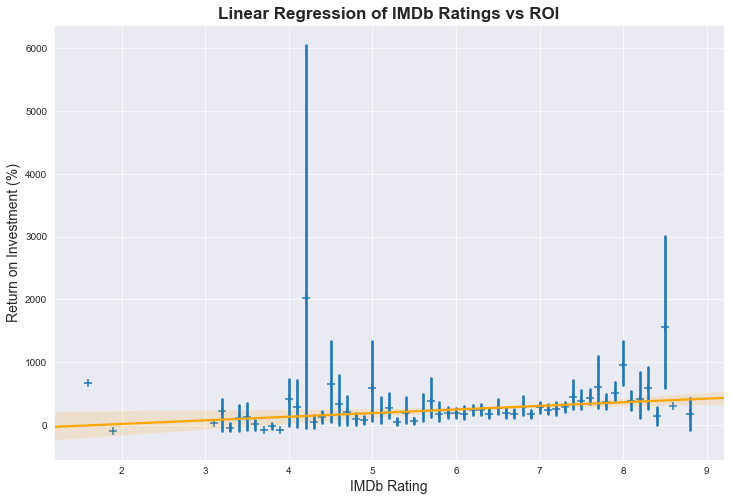

Correlation Coefficient w/out Outlier:
 [[1.         0.09969382]
 [0.09969382 1.        ]]
Correlation Coefficient w/ Outlier:
 [[ 1.         -0.00774102]
 [-0.00774102  1.        ]]


In [12]:
# Plot using table above
plt.figure(figsize =(12,8))
sns.regplot(data= roi_rat_df, x= 'averagerating', y= 'roi_%',
           marker= '+', x_estimator=np.mean,
           line_kws={"color": "orange"})
plt.xlabel('IMDb Rating', fontsize = 14)
plt.ylabel('Return on Investment (%)', fontsize = 14)
plt.title('Linear Regression of IMDb Ratings vs ROI', fontsize = 17, fontweight = 'bold')
plt.show()


#Just in case the visualization is not clear, let's calculate it.
print("Correlation Coefficient w/out Outlier:\n", np.corrcoef(roi_rat_df['averagerating'], roi_rat_df['roi_%']))
print("Correlation Coefficient w/ Outlier:\n", np.corrcoef(roi_rat_df_1['averagerating'], roi_rat_df_1['roi_%']))

### Looking a bit deeper
In this graph the outlier was included because having a view of this chart zoomed in is less important. The difference from the graph above is the x values. 

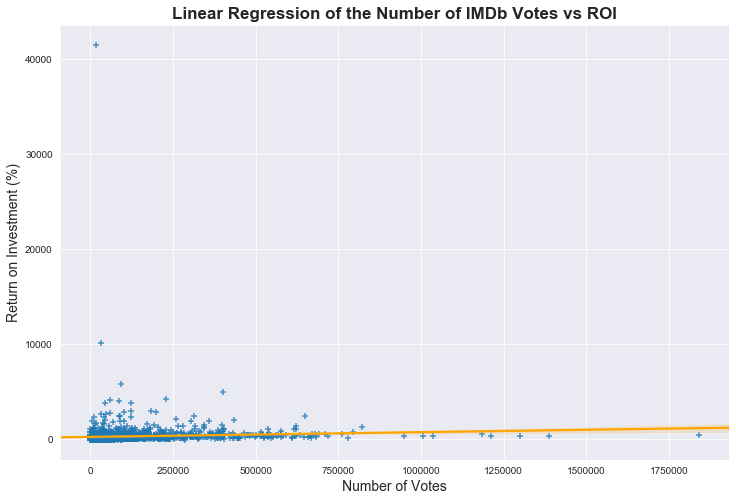

Correlation Coefficient w/out Outlier:
 [[1.         0.18031359]
 [0.18031359 1.        ]]
Correlation Coefficient w/ Outlier:
 [[1.         0.06704917]
 [0.06704917 1.        ]]


In [13]:
plt.figure(figsize =(12, 8))
sns.regplot(data= roi_rat_df_1, x= 'numvotes', y= 'roi_%',
           marker= '+', line_kws={"color": "orange"})
plt.xlabel('Number of Votes', fontsize = 14)
plt.ylabel('Return on Investment (%)', fontsize = 14)
plt.title('Linear Regression of the Number of IMDb Votes vs ROI', fontsize = 17, fontweight = 'bold')
plt.show()

#Just in case the visualization is not clear, let's calculate it.
print("Correlation Coefficient w/out Outlier:\n", np.corrcoef(roi_rat_df['numvotes'], roi_rat_df['roi_%']))
print("Correlation Coefficient w/ Outlier:\n", np.corrcoef(roi_rat_df_1['numvotes'], roi_rat_df_1['roi_%']))

## Question 1: Conclusion
***
The chart shows that there is a low positive correlation between a movie's ratings on IMDb and the ROI generated from it. However, this was with one significant outlier (40,000% ROI) removed to make the visual more effective. With that outlier added to the data, the correlation coefficient fell to a very low negative correlation. 

Ultimately, **there does not appear to be any significant correlation between a movie's IMDb rating and the returns it generates.** For any further research into the film industry I advise against using a movie's ratings as a benchmark for success. There is no tangible reward to investors for focusing on critical reviews. In other words, follow the money. Interestingly, it seems that there is a slightly stronger but still insignificant correlation between the number of votes a movie received and its returns. This may indicate that popularity is a better predictor of success than perception of quality. 


Future Work: I would like to run a correlation analysis of all movie rating platforms to see whether there is any one that correlates with a movie's returns. Also, looking into popularity ratings (I know that one of the databases provided included a column for that but I ran out of time).

## Question 2: Which Studio should we partner with?
***

There are two numbers that are important here: returns and frequency. It is important to consider frequency of operations when determining a suitable studio partner. Reason follows that a studio that only makes one movie a year will have a long waitlist. It is important to balance frequency with returns to ensure that we have a real chance of partnering with the proposed firm. 

To determine the answer to this question there will be a two-fold approach:

1. Determine the best studios based on frequency and **Mean Total Gross**. This graph will be based on df_budgets_2 (renamed to df_gross) which has studio information for every row. 

2. Determine the best studios based on frequency and **Mean ROI**. This will be based on the merged budgets df. This has fewer rows containing studio, but it has accurate ROI information. 



### Calculated using Mean Total Gross
***


In [14]:
# Load IMDB Gross csv file
df_gross = pd.read_csv(csv_files[0])

# Convert foreign_gross to int
df_gross['foreign_gross'].fillna(0, inplace = True)
new_foreign = []
for i in df_gross['foreign_gross']:
    if type(i) == int:
        new_foreign.append(float(i))
    else:
        new_foreign.append(float(i.replace(',', '')))
df_gross['foreign_gross'] = new_foreign    

# Create Total Gross
df_gross['total_gross'] = df_gross['domestic_gross'] + df_gross['foreign_gross']
df_gross.sort_values('total_gross',ascending=False, inplace = True)

# Drop studio Null
df_gross.dropna(subset = ['studio'], inplace = True)

print(df_gross.info())
df_gross.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 727 to 2595
Data columns (total 6 columns):
title             3382 non-null object
studio            3382 non-null object
domestic_gross    3356 non-null float64
foreign_gross     3382 non-null float64
year              3382 non-null int64
total_gross       3356 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 185.0+ KB
None


,title,studio,domestic_gross,foreign_gross,year,total_gross
727,Marvel's The Avengers,BV,623400000.0,895500000.0,2012,1.518900e+09
1875,Avengers: Age of Ultron,BV,459000000.0,946400000.0,2015,1.405400e+09
3080,Black Panther,BV,700100000.0,646900000.0,2018,1.347000e+09
328,Harry Potter and the Deathly Hallows Part 2,WB,381000000.0,960500000.0,2011,1.341500e+09
2758,Star Wars: The Last Jedi,BV,620200000.0,712400000.0,2017,1.332600e+09


#### Graph it

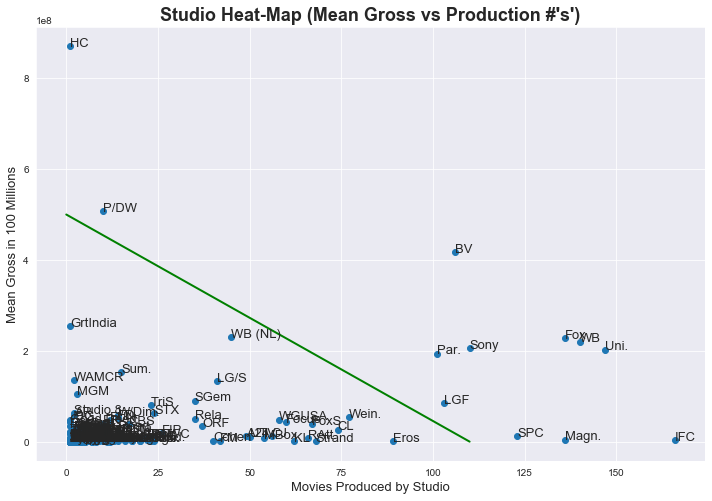

In [16]:
# Create a list of studios
studios = df_gross['studio'].unique()

# Create a list of average gross by using the loc operator with the studio list 
mean_gross = []
for i in studios:
    mean_gross.append((df_gross['total_gross'].loc[df_gross['studio'] == i]).mean())
num_movies = []
for i in studios:
    num_movies.append(len(df_gross.loc[df_gross['studio'] == i]))

# Plot it
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(num_movies, mean_gross)
ax.set_title("Studio Heat-Map (Mean Gross vs Production #'s')", fontsize = 18, fontweight = 'bold')
ax.set_xlabel("Movies Produced by Studio", fontsize = 13)
ax.set_ylabel("Mean Gross in 100 Millions", fontsize = 13)

# This places names next to the points
for i, txt in enumerate(studios):
    ax.annotate(txt, (num_movies[i], mean_gross[i]), fontsize = 13)

# Line drawn visually to seperate out 12 studios
plt.plot([0,110], [500000000, 0], color='g', linestyle='-', linewidth=2)
plt.show()

### Calculated using Mean ROI
***
This table uses a more important benchmark (ROI) but doesn't have as many rows as the table above. Together they should create a more balanced view of the best studio choice. 

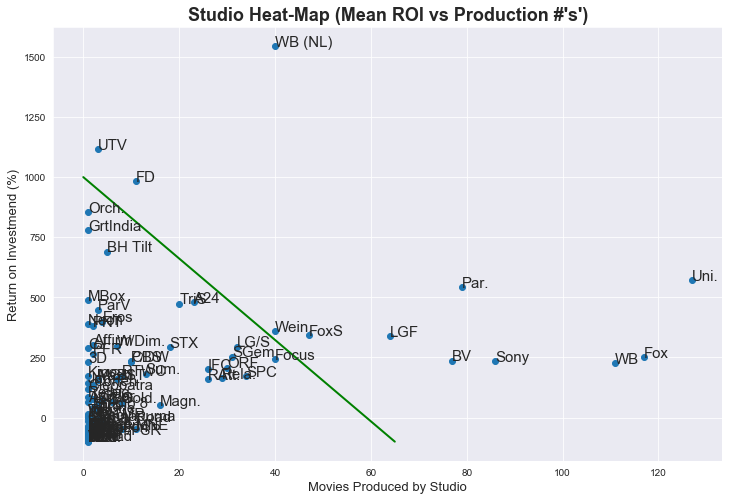

In [17]:
# Create new df
df_roi_studio = df

# Drop all rows with no studio data
df_roi_studio.dropna(subset = ['studio'], inplace = True)


studios = df_roi_studio['studio'].unique()

mean_roi = []
for i in studios:
    mean_roi.append((df_roi_studio['roi_%'].loc[df_roi_studio['studio'] == i]).mean())

roi_num_movies = []
for i in studios:
    roi_num_movies.append(len(df_roi_studio.loc[df_roi_studio['studio'] == i]))
    
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(roi_num_movies, mean_roi)
ax.set_title("Studio Heat-Map (Mean ROI vs Production #'s')", fontsize = 18, fontweight = 'bold')
ax.set_xlabel("Movies Produced by Studio", fontsize = 13)
ax.set_ylabel("Return on Investmend (%)", fontsize = 13)

# This places names next to the points
for i, txt in enumerate(studios):
    ax.annotate(txt, (roi_num_movies[i], mean_roi[i]), fontsize = 15)

# Line drawn visually to seperate out 12 studios
plt.plot([0,65], [1000, -100], color='g', linestyle='-', linewidth=2)
plt.show()

### Calculating Best Studio Mathematically
***
This allows us to take the data from the tables above and add them together. The first table provides more data on the studios and the second table provides a more relevant benchmark. 

In [18]:
# Creating a combined value of the roi performance of studios
roi_results = []

for i in range(len(roi_num_movies)):
    roi_results.append(roi_num_movies[i] / 100 * mean_roi[i])

# Creating a combined value of the gross performance of studios
gross_results = []

for i in range(len(num_movies)):
    gross_results.append(num_movies[i] / 100000000 * mean_gross[i])

# Create a dictionary for each list above     
roi = {studios[i]: roi_results[i] for i in range(len(studios))} 
gross = {studios[i]: gross_results[i] for i in range(len(studios))} 

# Create data frames for each dictionary
roi_test = pd.DataFrame.from_dict(roi, orient = 'index', columns = ['calc'])
gross_test = pd.DataFrame.from_dict(gross, orient = 'index', columns = ['calc'])

# Merge the two data frames
results_merged = roi_test.merge(gross_test, left_index = True, right_index = True)

# Create a new column containing the two combined values averaged
results_merged['total'] = (results_merged['calc_x'] + results_merged['calc_y']) /2

# Order the studios based on total value and print the first 5
results_merged.sort_values('total',ascending=False, inplace = True)
results_merged['total'][:5]

Uni.       476.096344
WB (NL)    334.160500
BV         312.125919
Par.       311.746778
WB         279.341245
Name: total, dtype: float64

## Question 2: Conclusion
***
The following studios were present in both graphs in a favourable region and were determined to be the best choices as partners for this project (in order of preference):

1. Universal Studios
2. Warner Bros (NL)
3. BV
4. Paramount
5. Warner Bros

**Universal Studios** has a significant lead over the next studio and is the **recommended studio partner**.

The original idea had been to draw conclusions visually from the graph, but this led to educated guesses at best. To determine a more mathematically sound answer, the values for each studio from each graph were averaged to find an overall score (the number itself is arbitrary and serves as an indicator of relativity). The scores of the top five and the code to get them can be found above. 

## Question 3: Which Genre is the most likely to be profitable?
***
Answering this question will allow us to determine which genre of movie is the most likely to generate the most revenue. 

### Selecting and Modifying Data
***

In [19]:
# Working with previous dataframe but removing superfluous columns
genre_df = roi_rat_df_1.drop(['averagerating', 'numvotes', 'domestic_gross'], axis = 1)

# Checking how many blank entries in 'genres'
print(genre_df['genres'].isna().sum())

# Dropping blank 'genres'
genre_df.dropna(subset = ['genres'], inplace = True)

# Checking whether dropna was succesful
print(genre_df['genres'].isna().sum())

# Ordering df by ROI
genre_df.sort_values('roi_%', ascending = False, inplace = True)

# Create a new Net Profit column
genre_df['net_profit'] = genre_df['worldwide_gross'] - genre_df['production_budget']

genre_df.head()

2
0


,tconst,primary_title,original_title,start_year,runtime_minutes,genres,production_budget,worldwide_gross,roi_%,net_profit
976,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller",100000,41656474,41556.5,41556474
344,tt1560985,The Devil Inside,The Devil Inside,2012,83.0,Horror,1000000,101759490,10075.9,100759490
221,tt1536044,Paranormal Activity 2,Paranormal Activity 2,2010,91.0,Horror,3000000,177512032,5817.1,174512032
922,tt5052448,Get Out,Get Out,2017,104.0,"Horror,Mystery,Thriller",5000000,255367951,5007.4,250367951
177,tt4975722,Moonlight,Moonlight,2016,111.0,Drama,1500000,65245512,4249.7,63745512


### Counting the Appearances of each Genre
***
The aim here is to see how often genres appear in the movies with the highest returns. This will be set against Gross and ROI. ROI is the driver behind this research, but having the Gross figures might add some perspective. 

The output from the cell below did not prove relevant, it would be more indicative of which genres perform well if the df only contained the best performing movies.

In [20]:
# Creating a list containing every genre within the data frame. 
genre_list = []
for i in genre_df['genres'].map(lambda x: x.split(",")):
    genre_list += i
    
# Imported counter to facilitate counting values. It was easier than creating a function.
Counter(genre_list)

Counter({'Horror': 156,
         'Mystery': 118,
         'Thriller': 239,
         'Drama': 677,
         'Action': 418,
         'Biography': 130,
         'Fantasy': 118,
         'Romance': 181,
         'Comedy': 484,
         'Music': 47,
         'Sci-Fi': 126,
         'Crime': 220,
         'Adventure': 342,
         'Animation': 98,
         'Family': 88,
         'Documentary': 32,
         'Sport': 33,
         'History': 39,
         'Musical': 8,
         'Western': 9,
         'War': 17})

### Genres in Top 200 ROI Movies

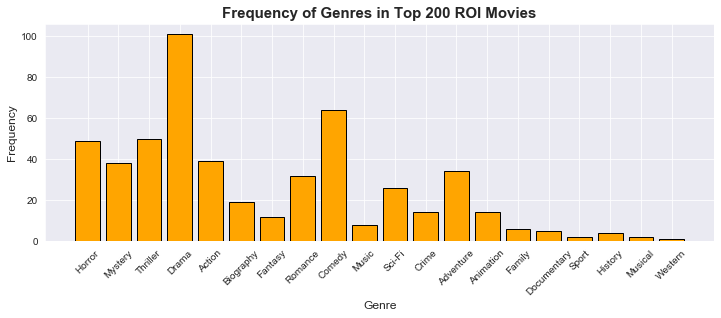

In [21]:
# genre_df is already ordered by ROI
top_200 = genre_df['genres'][:200]

# Split each line of genres into individual strings
genre_list = []
for i in top_200.map(lambda x: x.split(",")):
    genre_list += i

# Used counter again to avoid hard coding it
genre_200= Counter(genre_list)

plt.figure(figsize=(12, 4))
plt.bar(genre_200.keys(), genre_200.values(), color = 'orange', edgecolor = 'black')
plt.title('Frequency of Genres in Top 200 ROI Movies', fontsize = 15, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Genre', fontsize = 12)
plt.xticks(rotation= 45) # Rotates x-values by 45 degrees
plt.show()

### Genres in Top 200 Gross Movies

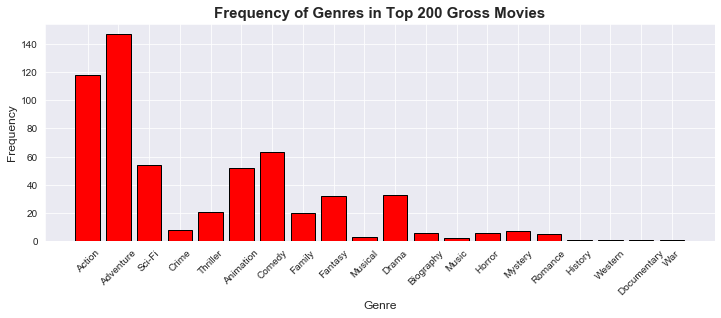

In [22]:
# Re-ordered df by Gross
gross_200 = genre_df.sort_values('worldwide_gross', ascending = False)

# Cut the first 200
gross_200 = gross_200['genres'][:200]

# Create a list of all the genres that appear in the top 200
genre_gross = []
for i in gross_200.map(lambda x: x.split(",")):
    genre_gross += i
    
gross_list = Counter(genre_gross)

plt.figure(figsize=(12, 4))
plt.bar(gross_list.keys(), gross_list.values(), color = 'red', edgecolor = 'black')
plt.title('Frequency of Genres in Top 200 Gross Movies', fontsize = 15, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Genre', fontsize = 12)
plt.xticks(rotation= 45)
plt.show()

### Now Together
To make this work I had to make a dataframe of the combined data from the two tables above plus an additional average column. Then, I used pd.melt to put the df in a format that seaborn can read. This extends the length of the dataframe but creates a column that can be used for the sns operator hue. 

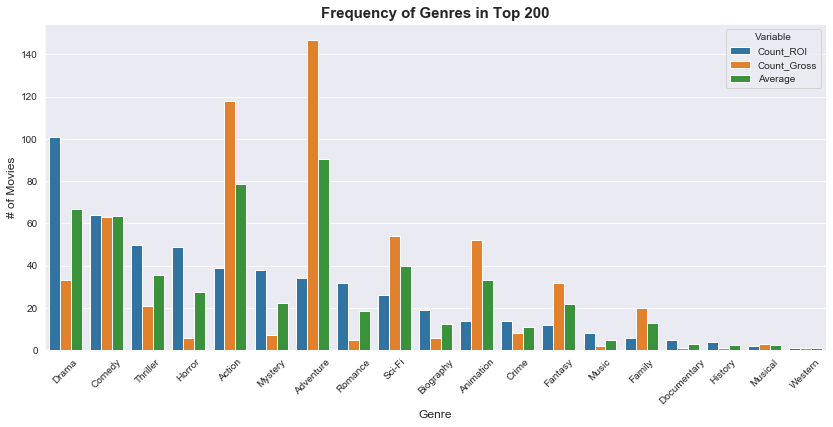

In [23]:
# Create a data frame with the Top 200 data for each one.
roi_genre_df = pd.DataFrame({
    'Genre': [i for i in genre_200.keys()],
    'Count_ROI': [i for i in genre_200.values()],
})

gross_genre_df = pd.DataFrame({
    'Genre': [i for i in gross_list.keys()],
    'Count_Gross': [i for i in gross_list.values()],
})

# Merge the two dataframes
top_200_merged = roi_genre_df.merge(gross_genre_df, left_on = 'Genre', right_on = 'Genre')

# Add an average columns
top_200_merged['Average'] = (top_200_merged['Count_ROI'] + top_200_merged['Count_Gross']) / 2

# Order by Average
top_200_merged.sort_values('Count_ROI', ascending = False, inplace = True)

fig, ax1 = plt.subplots(figsize=(14, 6))

# pandas.melt turns a dataframe into a format that sns can graph more easily
tidy = top_200_merged.melt(id_vars = 'Genre').rename(columns = str.title)

sns.barplot(x='Genre', y='Value', hue='Variable', data=tidy, ax = ax1)
plt.xticks(rotation = 45)
plt.xlabel('Genre', fontsize = 12)
plt.ylabel('# of Movies', fontsize = 12)
plt.title("Frequency of Genres in Top 200", fontsize = 15, fontweight = 'bold')
plt.show()

#### Findings
The best genres based on ROI (the more important metric) appear to be Drama and Comedy. However, what this graph does not account for, is the amount of money that goes into production of different genres. Action and Adventure regularly gross the highest but they obviously have higher costs of production (CGI being key among them). Drama and Comedy on the other hand is primarily budgeted against the actors in it. 

What would actually allow conclusions to be drawn for this Question is setting the information above against the different costs of production thresholds for each genre.

### Genre returns set against Budget 
***
This was a long process

In [24]:
# Create a new df, drop unnecessary columns, order it by budget and turn each genres item into a list.
production_budget_df = genre_df.sort_values('production_budget')
production_budget_df.drop(['tconst', 'runtime_minutes', 'original_title', 'start_year'], axis = 1, inplace = True)
production_budget_df['genres'] = production_budget_df['genres'].map(lambda x: x.split(","))

# This will be used to split the data into four sections
length = len(production_budget_df)

# Find the quartile ranges of budget to separate into four groups
# This actually turned out to be unecessary but I left it in cause I thought it was cool
q0 = production_budget_df['production_budget'].min()
q1 = production_budget_df['production_budget'][:int(length/4)].max()
q2 = production_budget_df['production_budget'][int(length/4):int(2*length/4)].max()
q3 = production_budget_df['production_budget'][int(2*length/4):int(3*length/4)].max()
q4 = production_budget_df['production_budget'].max()

# Create four dataframes for each quarter. Use explode to split each row with multiple genres into multiple rows
df1 = production_budget_df[:int(length/4)]
ef1 = df1.explode('genres')
df2 = production_budget_df[int(length/4):int(2*length/4)]
ef2 = df2.explode('genres')
df3 = production_budget_df[int(2*length/4):int(3*length/4)]
ef3 = df3.explode('genres')
df4 = production_budget_df[int(3*length/4):]
ef4 = df4.explode('genres')

# Create a list of the unique genres in each df
a1 = []
for i in df1['genres']:
    a1 += i
a1 = set(a1)
a2 = []
for i in df2['genres']:
    a2 += i
a2 = set(a2)
a3 = []
for i in df3['genres']:
    a3 += i
a3 = set(a3)
a4 = []
for i in df4['genres']:
    a4 += i
a4 = set(a4)

# Create a list of the average ROI for each genre
b1 = []
for i in a1:
    b1.append(ef1.loc[ef1['genres'] == i]['roi_%'].mean())
b2 = []
for i in a2:
    b2.append(ef2.loc[ef2['genres'] == i]['roi_%'].mean())
b3 = []
for i in a3:
    b3.append(ef3.loc[ef3['genres'] == i]['roi_%'].mean())
b4 = []
for i in a4:
    b4.append(ef4.loc[ef4['genres'] == i]['roi_%'].mean())

# Create a df for each budget range
c1 = pd.DataFrame({
    'Genre' : [i for i in a1],
    'Budget' : "budget < 10000000",
    'Average_ROI' : [i for i in b1]
})
c2 = pd.DataFrame({
    'Genre' : [i for i in a2],
    'Budget' : "10000000 < budget < 25000000",
    'Average_ROI' : [i for i in b2]
})
c3 = pd.DataFrame({
    'Genre' : [i for i in a3],
    'Budget' : "25000000 < budget < 60000000",
    'Average_ROI' : [i for i in b3]
})
c4 = pd.DataFrame({
    'Genre' : [i for i in a4],
    'Budget' : "budget > 60000000",
    'Average_ROI' : [i for i in b4]
})

# Merge all the dataframes into one
d = c1.merge(c2, how = 'outer')
d = d.merge(c3, how = 'outer')
d = d.merge(c4, how = 'outer')

#### Graph it

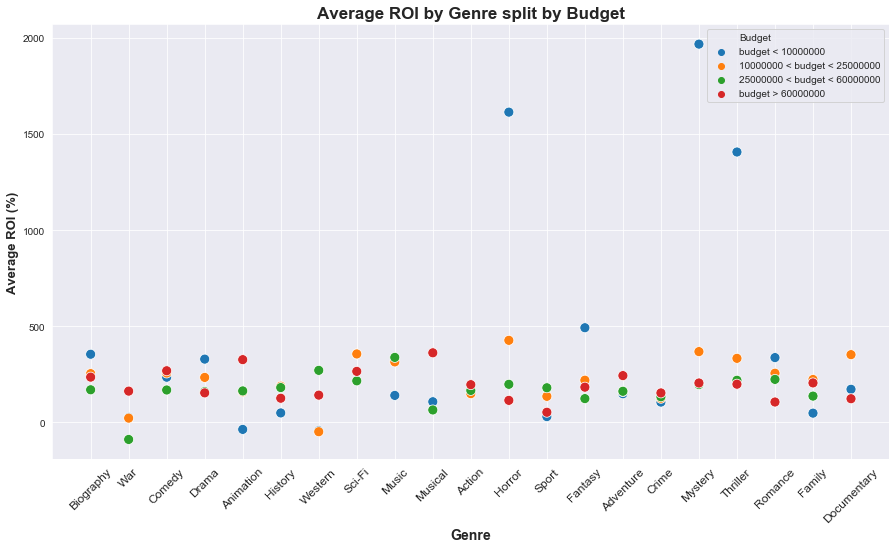

In [25]:
# Used seaborn to create a scatter plot of each genres ROI based on budget
fig, ax1 = plt.subplots(figsize=(15, 8))
sns.scatterplot(x="Genre", y="Average_ROI", hue="Budget", data=d, ax = ax1, s= 100) # s sets the size of the points
plt.xticks(rotation = 45, fontsize = 12)
plt.xlabel('Genre', fontsize = 14, fontweight = 'bold')
plt.ylabel('Average ROI (%)', fontsize = 13, fontweight = 'bold')
plt.title("Average ROI by Genre split by Budget", fontsize = 17, fontweight = 'bold')
plt.show()

## Question 3: Conclusion
***
While action and adventure movies show up most often in the highest grossing films and form a large portion of the highest grossing movies, they do not score well in terms of Return on Investment. This might have to do with higher costs of production that come with CGI and more equipment intensive filming. 

The conclusions that can be drawn of this question differ based on the intended movie budget. **The bottom line, highest returning movie genres in any category are low budget (less than 10 million) Mystery, Horror, and Thriller movies.** Their categories often overlap in the same movies so they share a lot of data, but each of their averages returns more than 800% higher than any other average return. Amongst them, Mystery is the highest performing with an average return of just under 2,000% for low budget films. 

For other budgets, the playing field is significantly more level. For 10 to 25 million budgets, Horror is still the top pick by a small margin, followed closely by Mystery and Sci-Fi. **For big budget movies (60 mil plus) the highest consistent returns are from Musicals and Animated movies.** 

The clear recommendation is for a lower budget Horror/Mystery movie. The ROI generated from them is in large part due to the documentary style recording of many horror movies that do not require much in the form of set or crew. Paranormal Activity, which was not included in the final table, made a return of nearly 550,000%!